In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from sklearn import metrics
from IPython import display
from tensorflow.python.data import Dataset
import math
tf.logging.set_verbosity(tf.logging.ERROR)
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import pandas_profiling
from time import gmtime, strftime
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
warnings.filterwarnings('ignore')
%matplotlib inline

#### 1) Custom DNN regressor with estimator
#### 2) CNN sequential Keras API
#### 3) CNN functional Keras API

In [8]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [9]:
def preprocess_data(df_train):
    df_train_rand = df_train.reindex(np.random.permutation(df_train.index))
    return df_train_rand

In [10]:
def preprocess_features(x_train):
    #Normalization to greyscale, reduces the effect of illumination's differences
    x_train_norm = x_train / 255.0
    #Reshaping for keras 28x28x1 3D matrices?
    x_train_norm = x_train_norm.values.reshape(-1, 28, 28, 1)
    return x_train_norm

In [11]:
def preprocess_targets(y_train):
    #Encode labels to one hot vecs
    y_train_hot = to_categorical(y_train, num_classes=10)
    return y_train

In [12]:
df_train_rand = preprocess_data(df_train)
X_train = preprocess_features(df_train_rand.drop(labels = ['label'], axis = 1).head(38000).copy())
X_val = preprocess_features(df_train_rand.drop(labels = ['label'], axis = 1).tail(6000).copy())
Y_train = preprocess_targets(df_train_rand['label'].head(38000).copy())
Y_val = preprocess_targets(df_train_rand['label'].tail(6000).copy())

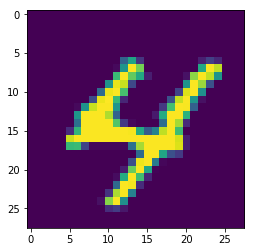

In [14]:
g = plt.imshow(X_train[0][:,:,0])

Filters are transformations of the image.
Filters' size is defined by kernel size
